<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Comparative-Genomics-analysis-for-16S" data-toc-modified-id="Comparative-Genomics-analysis-for-16S-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Comparative Genomics analysis for 16S</a></span></li></ul></div>

In [1]:
# This block is just for importing the necessary libraries.  
import os
from collections import defaultdict
# Numerical libraries
import pandas as pd
import numpy as np
import biom
import arviz as az
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr

from gneiss.balances import sparse_balance_basis
# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib_venn import venn2, venn3
# custom utility and plotting functions
from util import (extract_differentials, select_features, 
                  get_genomic_data, collapse_transcripts, 
                  aggregate_pathways,
                  ranking, btest, log_pvalue, read_kegg_dict,
                  ilr_transform_differentials,
                  rename_clades, create_projection,
                  match_all_differentials)
from plot import (rankplot, networkplot, vectorplot)
import random

# directory paths
amp_ibd_directory = '../sfari/data/sra_ibd_amplicon/Combined'
wgs_ibd_directory = '../sfari/data/sra_ibd_shotgun/Combined'

amp_asd_directory = '../sfari/data/sra/Combined'
wgs_asd_directory = '../sfari/data/sra_shotgun/Combined'

results_dir = '../results'
kegg_dir = f'{results_dir}/kegg'
hsa_dir = f'{results_dir}/hsa_kegg'
np.random.seed(0)
random.seed(0)
%matplotlib inline

In [2]:
# load 16S, whole genome shotgun IBD data
posterior_name = 'sex_matched_posterior'
amp_fname = f'{amp_ibd_directory}/{posterior_name}/amp_differentials.nc'
wgs_fname = f'{wgs_ibd_directory}/{posterior_name}/wgs_differentials.nc'
amp_ibd_diffs = extract_differentials(amp_fname)
wgs_ibd_diffs = extract_differentials(wgs_fname)
# load 16S, whole genome shotgun ASD data
posterior_name = 'age_sex_matched_posterior'
amp_fname = f'{amp_asd_directory}/{posterior_name}/amp_differentials-v3.nc'
wgs_fname = f'{wgs_asd_directory}/{posterior_name}/ogus_differentials-v3.nc'
amp_asd_diffs = extract_differentials(amp_fname)
wgs_asd_diffs = extract_differentials(wgs_fname)
# Compute statistical tests for each data layer
# Here, we will only focus on the top 10% of the features
amp_ibd_stats = ranking(amp_ibd_diffs, reference_percentile=90)
wgs_ibd_stats = ranking(wgs_ibd_diffs, reference_percentile=90)
amp_asd_stats = ranking(amp_asd_diffs, reference_percentile=90)
wgs_asd_stats = ranking(wgs_asd_diffs, reference_percentile=90)

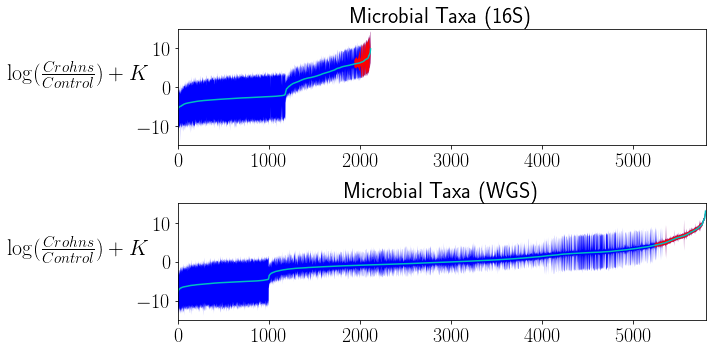

In [3]:
matplotlib.rcParams['text.usetex'] = True
# Plot the log-fold changes
#with plt.style.context('dark_background'):
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
fs, ls = 22, 20
rankplot(amp_ibd_stats, ax[0])
ax[0].set_title('Microbial Taxa (16S)', fontsize=fs)
ax[0].set_ylim([-15, 15])
ax[0].set_xlim([0, len(wgs_ibd_stats)])
ax[0].set_ylabel(r'$\log(\frac{Crohns}{Control})+K$', fontsize=fs, labelpad=60)
ax[0].tick_params(axis='x', labelsize=ls)
ax[0].tick_params(axis='y', labelsize=ls)

rankplot(wgs_ibd_stats, ax[1])
ax[1].set_title('Microbial Taxa (WGS)', fontsize=fs)
ax[1].set_ylim([-15, 15])
ax[1].set_xlim([0, len(wgs_ibd_stats)])
ax[1].set_ylabel(r'$\log(\frac{Crohns}{Control})+K$', fontsize=fs, labelpad=60)
ax[1].tick_params(axis='x', labelsize=ls)
ax[1].tick_params(axis='y', labelsize=ls)

plt.tight_layout()

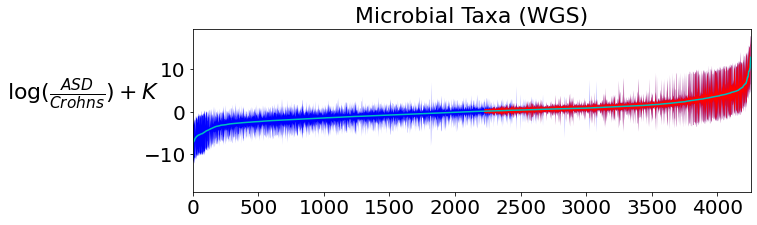

In [7]:
matplotlib.rcParams['text.usetex'] = False
common_taxa = list(set(wgs_ibd_diffs.index) & set(wgs_asd_diffs.index))
asd_ibd_diffs = wgs_asd_diffs.loc[common_taxa] - wgs_ibd_diffs.loc[common_taxa]
asd_ibd_stats = ranking(asd_ibd_diffs, reference_percentile=50)

fig, ax = plt.subplots(figsize=(10, 3))

rankplot(asd_ibd_stats, ax)
ax.set_title('Microbial Taxa (WGS)', fontsize=fs)
#ax.set_ylim([-15, 15])
ax.set_xlim([0, len(asd_ibd_stats)])
ax.set_ylabel(r'$\log(\frac{ASD}{Crohns})+K$', fontsize=fs, labelpad=60)
ax.tick_params(axis='x', labelsize=ls)
ax.tick_params(axis='y', labelsize=ls)

Amplicon agreement across diseases

In [ ]:
matplotlib.rcParams['text.usetex'] = False

common_amp_taxa = list(set(amp_ibd_stats.index) & set(amp_asd_stats.index))
amp_ibd = amp_ibd_stats.loc[common_amp_taxa]
amp_asd = amp_asd_stats.loc[common_amp_taxa]

fig, ax = plt.subplots(figsize=(5, 5))
y, x = amp_asd['mean'], amp_ibd['mean']

sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(x=x, y=y, bins=30, pthresh=.1, cmap="viridis")
sns.kdeplot(x=x, y=y, levels=10, color="gray", linewidths=1)
sns.regplot(x=x, y=y, order=2, color="red", scatter=False, fit_reg=True)

plt.ylabel('log(ASD/Control)', fontsize=14)
plt.xlabel('log(CD/Control)', fontsize=14)

spearmanr(x, y)

In [ ]:
# Venn diagram to visualize overlap
#with plt.style.context('dark_background'):
venn2([set(amp_asd_stats.index), 
       set(amp_ibd_stats.index)], 
      set_labels=['ASD', 'IBD'])
plt.title('All 16S Taxa')

WGS agreement across diseases

In [ ]:
matplotlib.rcParams['text.usetex'] = False

common_wgs_taxa = list(set(wgs_ibd_stats.index) & set(wgs_asd_stats.index))
wgs_ibd = wgs_ibd_stats.loc[common_wgs_taxa]
wgs_asd = wgs_asd_stats.loc[common_wgs_taxa]

fig, ax = plt.subplots(figsize=(3, 3))
y, x = wgs_asd['mean'], wgs_ibd['mean']
ax.scatter(x, y, alpha=0.5, s=1)

from matplotlib.ticker import MaxNLocator
ax.yaxis.set_major_locator(MaxNLocator(3)) 
r = pearsonr(x, y)
ax.annotate(f'r={np.round(r[0], 2)}', xy=(-8, 12), fontsize=14)

ax.set_ylabel('log(ASD/Control)', fontsize=14)
ax.set_xlabel('log(CD/Control)', fontsize=14)
ax.set_xlim([-10, 15])
ax.set_ylim([-10, 15])
ax.plot(np.linspace(-10, 15), np.linspace(-10, 15), c='r')
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
venn2([set(wgs_ibd_stats.index), 
       set(wgs_asd_stats.index)], 
      set_labels=['ASD', 'IBD'], ax=ax)

In [ ]:
common_wgs_taxa = list(set(wgs_ibd_stats.index) & set(wgs_asd_stats.index))
wgs_ibd = wgs_ibd_stats.loc[common_wgs_taxa]
wgs_asd = wgs_asd_stats.loc[common_wgs_taxa]

sns.set_theme(style="dark")
fig, ax = plt.subplots(figsize=(5, 5))
x, y = wgs_asd['mean'], wgs_ibd['mean']

sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(x=x, y=y, bins=30, pthresh=.1, cmap="viridis")
sns.kdeplot(x=x, y=y, levels=10, color="gray", linewidths=1)
sns.regplot(x=x, y=y, order=1, color="red", scatter=False, fit_reg=True)

plt.xlabel('log(ASD/Control)', fontsize=14)
plt.ylabel('log(CD/Control)', fontsize=14)

spearmanr(x, y)

Effect size estimates

In [ ]:
# Perform Bayesian hypothesis test
from q2_matchmaker._stats import spherical_test
w_asd, asd_r, asd_z = spherical_test(amp_asd_diffs.values.T, p=1)
w_ibd, ibd_r, ibd_z = spherical_test(amp_ibd_diffs.values.T, p=1)

asd_ea = np.round(asd_z / asd_r, 2)
ibd_ea = np.round(ibd_z / ibd_r, 2)

print(f'[16S] ASD diff detected {not w_asd}, '
      f'Effect size {asd_ea}')
print(f'[16S] IBD diff detected {not w_ibd}, '
      f'Effect size {ibd_ea}')

# shotgun
w_asd, asd_r, asd_z = spherical_test(wgs_asd_diffs.values.T, p=1)
w_ibd, ibd_r, ibd_z = spherical_test(wgs_ibd_diffs.values.T, p=1)

asd_ew = np.round(asd_z / asd_r, 2)
ibd_ew = np.round(ibd_z / ibd_r, 2)

print(f'[WGS] ASD diff detected {not w_asd}, '
      f'Effect size {asd_ew}')
print(f'[WGS] IBD diff detected {not w_ibd}, '
      f'Effect size {ibd_ew}')

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.barh([0, 1, 2, 3], [asd_ea, ibd_ea, asd_ew, ibd_ew][::-1], height=0.7)
ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels(['ASD [16S]', 'IBD [16S]', 'ASD [WGS]', 'IBD [WGS]'][::-1])
ax.set_xlabel('Effect Size', fontsize=24)
ax.tick_params(axis='x', labelsize=18)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Comparative Genomics analysis for 16S

In [ ]:
# Perform binomial test on 16S data to determine uniquely identifying genes
amp_con, amp_asd = select_features(amp_asd_stats, alpha=0.1)
ko_amp = pd.read_table(f'{amp_asd_directory}/picrust2_out_pipeline/KO_predicted.tsv', 
                       index_col=0)
kegg_con_amp = ko_amp.align(amp_con, axis=0, join='inner')[0]
kegg_asd_amp = ko_amp.align(amp_asd, axis=0, join='inner')[0]
# apply binomial test.  Use BH correction to get per-gene pvalues
kegg_con_amp, kegg_asd_amp = btest(kegg_con_amp, kegg_asd_amp)
kegg_asd_amp = log_pvalue(kegg_asd_amp, alpha=0.1)
sig_asd = aggregate_pathways(
    pathway_name_file=f'{kegg_dir}/pathway_name.txt',
    pathway_to_ko_file=f'{kegg_dir}/pathway-to-ko.txt',
    features=kegg_asd_amp
)

In [ ]:
# Perform binomial test on 16S data to determine uniquely identifying genes
amp_con, amp_ibd = select_features(amp_ibd_stats, alpha=0.1)
ko_amp = pd.read_table(f'{amp_ibd_directory}/picrust2_out_pipeline/KO_predicted.tsv', 
                       index_col=0)
kegg_con_amp = ko_amp.align(amp_con, axis=0, join='inner')[0]
kegg_ibd_amp = ko_amp.align(amp_ibd, axis=0, join='inner')[0]
# apply binomial test.  Use BH correction to get per-gene pvalues
kegg_con_amp, kegg_ibd_amp = btest(kegg_con_amp, kegg_ibd_amp)
kegg_ibd_amp = log_pvalue(kegg_ibd_amp, alpha=0.1)
sig_ibd = aggregate_pathways(
    pathway_name_file=f'{kegg_dir}/pathway_name.txt',
    pathway_to_ko_file=f'{kegg_dir}/pathway-to-ko.txt',
    features=kegg_ibd_amp
)

In [ ]:
# Venn diagram to visualize overlap
#with plt.style.context('dark_background'):
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
venn2([set(amp_asd_stats.index), 
       set(amp_ibd_stats.index)], 
      set_labels=['ASD', 'IBD'], ax=ax[0])
ax[0].set_title('All 16S Taxa')

# Venn diagram to visualize overlap
#with plt.style.context('dark_background'):
venn2([set(amp_asd.index), 
       set(amp_ibd.index)], 
      set_labels=['ASD', 'IBD'], ax=ax[1])
ax[1].set_title('Top 10\% Taxa')

# Venn diagram to visualize overlap
#with plt.style.context('dark_background'):
venn2([set(kegg_asd_amp['KEGG']), 
       set(kegg_ibd_amp['KEGG'])], 
      set_labels=['ASD', 'IBD'], ax=ax[2])
ax[2].set_title('Unique KEGG functions \n of Top 10\% Taxa')

In [ ]:
# Visualize KEGG counts for 16S data
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
pwy_counts = sig_asd['Name'].value_counts().sort_values(ascending=True)
# only focus on highly representive pathways
pwy_counts = pwy_counts.loc[pwy_counts > 50] 
ax[0].barh(pwy_counts.index, pwy_counts.values)
ax[0].set_xlabel('[ASD] Number of KEGGs', fontsize=14)

pwy_counts = sig_ibd['Name'].value_counts().sort_values(ascending=True)
# only focus on highly representive pathways
pwy_counts = pwy_counts.loc[pwy_counts > 50] 
ax[1].barh(pwy_counts.index, pwy_counts.values)
ax[1].set_xlabel('[IBD] Number of KEGGs', fontsize=14)
plt.tight_layout()